# Simple AUTOENCODER for PETALO

Esta red la vamos a utilizar para obtener el radio 

In [1]:
import numpy as np
#np.random.seed(1337)  # for reproducibility
from time import time
from datetime import datetime
from sklearn import preprocessing
import sys
print(sys.path)
sys.path.append("/home/rgadea/lmfit-py/")
import seaborn as sns
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD
from keras.utils import np_utils
from keras import regularizers
from math import floor
from lmfit.models import  GaussianModel
import matplotlib.pyplot as plt

['', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python36.zip', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/lib-dynload', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/extensions', '/home/rgadea3/.ipython']


Using TensorFlow backend.


## Vamos introducir los datos de petalo preprocesados en pyhton


In [2]:
import scipy.io as sio
import hdf5storage
# datos_matlab = hdf5storage.loadmat('../datos_junio_2019/conjunto_entrenamiento_junio_2019_pitch7mm_rad165mm_29_total.mat')
npzfile = np.load('../conjuntos_datos_reconstruidos/fil1_pith7mm_rad165mm_scaled2_sig_sig_1200.npz')
npzfile.files

conjunto_datos1= npzfile['arr_1']
npzfile = np.load('../conjuntos_datos_reconstruidos/fil2_pith7mm_rad165mm_scaled2_sig_sig_1200.npz')
npzfile.files

conjunto_datos2= npzfile['arr_1']

conjunto_datos=np.concatenate((conjunto_datos1,conjunto_datos2), axis=0)
print(conjunto_datos.shape)
print(conjunto_datos[:10,6:26])

(22703, 3518)
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 4.59627137e-02
  0.00000000e+00 3.93321030e-02 2.38600597e-02 1.10366344e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.36198878e-01 0.00000000e+00 2.38486826e-02 0.00000000e+00]
 [3.78941670e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 7.63966143e-02 2.33010277e-02
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.08729953e-02 1.83366984e-03 3.30588967e-03 6.81750476e-04
  2.23696232e-04 3.82469594e-03 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.77336234e-01 1.43314585e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 4.92163807e-01
  1.44141331e-01 6.95920408e-01 2.27891177e-01 0.00000000e+00
  5.68094969e-01 9.33814764e-01 7.97464848e-01 0.00000000e+00
  1.65551257e+00 3.11552691e+00 5.25702763e+00 4.69963837e+00]
 [3.56102377e-01 4.67843004e-02 0.00000000e+00 0.0000

## Network parameters:

In [3]:
batch_size = 1000
# aqui no aplicable porque es una regresion
# nb_classes = 10 

nb_epoch = 2000

n_hidden1=50
n_hidden2=20

# input image dimensions
img_rows, img_cols = 20, 31
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (4, 4)

## Prepare data into training and test set.

In [4]:
# the data, shuffled and split between train and test sets
# (X_train, y_train), (X_test, y_test) = mnist.load_data()
# conjunto_datos=photodefbox2_todo_e
numero_muestras=conjunto_datos.shape[0]
print(numero_muestras)
print('conjunto_datos shape:', conjunto_datos.shape)
maxInColumns = np.amax(conjunto_datos, axis=0)
print (maxInColumns[1])
# n, bins, patches = plt.hist(conjunto_datos[:,1], 400, normed=0, facecolor='green', alpha=0.75)


idea=conjunto_datos[:,6:3506]
veamos=idea.reshape(idea.shape[0],175, 20)
veamos2=np.zeros([idea.shape[0],20,175])
veamos2_3=np.zeros([idea.shape[0],20,525])
sector2=np.zeros([idea.shape[0],20,31])
veamos3=np.zeros([idea.shape[0],175])
# for i in range(idea.shape[0]):
for i in range(idea.shape[0]):
    veamos2[i]=np.reshape(veamos[i].transpose(), [20,175])
    veamos3[i]=np.sum(veamos2[i], axis=0)
    indice=np.argmax(veamos3[i], axis=0)
    veamos2_3[i]=np.concatenate((veamos2[i],veamos2[i],veamos2[i]),axis=1)   
    sector2[i]=veamos2_3[i,:,indice-15+175:indice+16+175]
    

print('sector shape:', sector2.shape)
conjunto_datos_nuevo=sector2.reshape(sector2.shape[0], img_rows*img_cols)
print('conjunto_datos_nuevo:', conjunto_datos_nuevo.shape)

print(idea[:10,:10])

22703
conjunto_datos shape: (22703, 3518)
194.99941139023045
sector shape: (22703, 20, 31)
conjunto_datos_nuevo: (22703, 620)
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 4.59627137e-02
  0.00000000e+00 3.93321030e-02]
 [3.78941670e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 7.63966143e-02 2.33010277e-02
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.77336234e-01 1.43314585e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 4.92163807e-01
  1.44141331e-01 6.95920408e-01]
 [3.56102377e-01 4.67843004e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 7.36187994e-02 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.12811126e-01 7.03886926e-01 1.31580794e+00 1.82600713e+00
  1.62912667e+00 2.48161149e+00 3.54922920e-01 2.33536935e+00
  3.91879416e+00 4.20606518e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.75582379

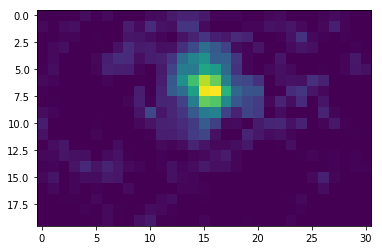

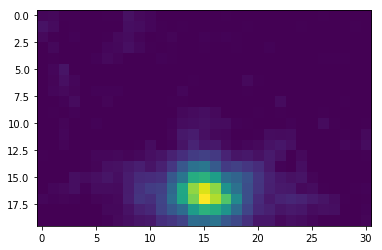

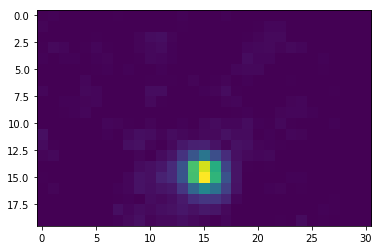

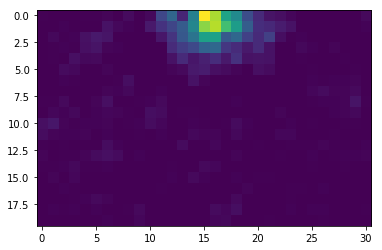

In [5]:
# convert class vectors to binary class matrices
#Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_test = np_utils.to_categorical(y_test, nb_classes)
for i in range(1,5):
    idea=np.random.randint(1,sector2.shape[0])
    plt.imshow(sector2[idea], cmap='viridis')
    plt.show()

In [6]:
tr_size=60
val_size=20
test_size=100-val_size-tr_size
conjunto_datos_nuevo2=np.concatenate((conjunto_datos[:,0:3],conjunto_datos_nuevo), axis=1)
tamanyo_tr=floor(tr_size*numero_muestras/100)
tamanyo_val=floor(val_size*numero_muestras/100)
tamanyo_test=numero_muestras-tamanyo_tr-tamanyo_val
print(tamanyo_tr)
print(tamanyo_val)
print(tamanyo_test)


XY_test=conjunto_datos_nuevo2[tamanyo_tr+tamanyo_val:numero_muestras,:]


XY_test_bin0=XY_test[np.where((XY_test[:,1]>=164.9999) * (XY_test[:,1]<171.000))]
XY_test_bin1=XY_test[np.where((XY_test[:,1]>=171.000) * (XY_test[:,1]<177.000))]
XY_test_bin2=XY_test[np.where((XY_test[:,1]>=177.000) * (XY_test[:,1]<183.0000))]
XY_test_bin3=XY_test[np.where((XY_test[:,1]>=183.000) * (XY_test[:,1]<189.0000))]
XY_test_bin4=XY_test[np.where((XY_test[:,1]>=189.0000))]

x_train=conjunto_datos_nuevo2[:tamanyo_tr,3:]
x_val=conjunto_datos_nuevo2[tamanyo_tr:tamanyo_tr+tamanyo_val,3:]
x_test=conjunto_datos_nuevo2[tamanyo_tr+tamanyo_val:numero_muestras,3:]

x_test_bin0=XY_test_bin0[:,3:]
Y_test_bin0=XY_test_bin0[:,1]
print(x_test_bin0.shape)
x_test_bin1=XY_test_bin1[:,3:]
Y_test_bin1=XY_test_bin1[:,1]
print(x_test_bin1.shape)
x_test_bin2=XY_test_bin2[:,3:]
Y_test_bin2=XY_test_bin2[:,1]
print(x_test_bin2.shape)
x_test_bin3=XY_test_bin3[:,3:]
Y_test_bin3=XY_test_bin3[:,1]
print(x_test_bin3.shape)
x_test_bin4=XY_test_bin4[:,3:]
Y_test_bin4=XY_test_bin4[:,1]
print(x_test_bin4.shape)



Y_train=conjunto_datos_nuevo2[:tamanyo_tr,1] #elijo la coordenada radius
Y_val=conjunto_datos_nuevo2[tamanyo_tr:tamanyo_tr+tamanyo_val,1] #elijo la corrdenada radius
Y_test=conjunto_datos_nuevo2[tamanyo_tr+tamanyo_val:numero_muestras,1] #elijo la corrdenada radius

13621
4540
4542
(1896, 620)
(851, 620)
(586, 620)
(585, 620)
(624, 620)


In [7]:
img_cols=31
img_rows=20

X_train = x_train.reshape(x_train.shape[0], img_rows, img_cols,1)
X_val = x_val.reshape(x_val.shape[0], img_rows, img_cols,1)
X_test = x_test.reshape(x_test.shape[0], img_rows, img_cols,1)

X_test_bin0 = x_test_bin0.reshape(x_test_bin0.shape[0], img_rows, img_cols,1)
X_test_bin1 = x_test_bin1.reshape(x_test_bin1.shape[0], img_rows, img_cols,1)
X_test_bin2 = x_test_bin2.reshape(x_test_bin2.shape[0], img_rows, img_cols,1)
X_test_bin3 = x_test_bin3.reshape(x_test_bin3.shape[0], img_rows, img_cols,1)
X_test_bin4 = x_test_bin4.reshape(x_test_bin4.shape[0], img_rows, img_cols,1)

input_shape = (img_rows, img_cols,1)
#input_shape=input_shape.astype('int32')

In [8]:
X_train = X_train.astype('float32')
X_val= X_val.astype('float32')
X_test = X_test.astype('float32')

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'validation samples')
print(X_test.shape[0], 'test samples')

X_train shape: (13621, 20, 31, 1)
13621 train samples
4540 validation samples
4542 test samples


Display 20 random training images using image

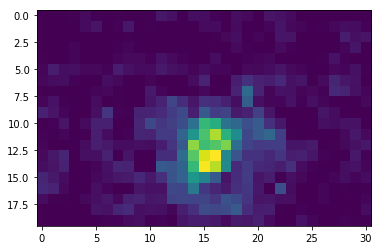

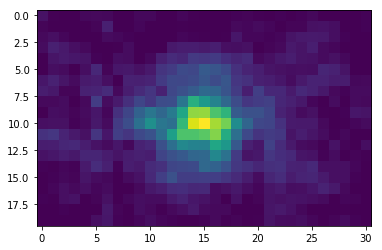

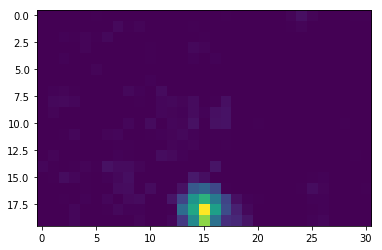

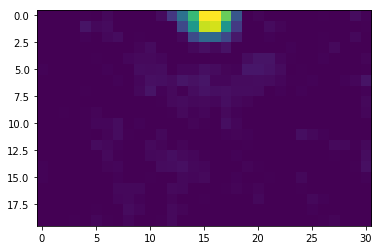

In [9]:
# convert class vectors to binary class matrices
#Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_test = np_utils.to_categorical(y_test, nb_classes)
for i in range(1,5):
    idea=np.random.randint(1,X_train.shape[0])
    plt.imshow(np.reshape(X_train[idea], [img_rows, img_cols]), cmap='viridis')
    plt.show()

## Build the MLP. 

In [10]:
print(x_val[:10,:10])

min_max_scaler = preprocessing.MinMaxScaler().fit(x_train)
#min_max_scaler = preprocessing.RobustScaler().fit(x_train)
# supermax=1
# factor_aprendizaje=0.0001
print(min_max_scaler)
# comentar las siguientes lineas si no queremos normalizar
# x_train = min_max_scaler.transform(x_train)
# x_val = min_max_scaler.transform(x_val)
# x_test = min_max_scaler.transform(x_test)
# x_test_bin0 = min_max_scaler.transform(x_test_bin0)
# x_test_bin1 = min_max_scaler.transform(x_test_bin1)
# x_test_bin2 = min_max_scaler.transform(x_test_bin2)
# x_test_bin3 = min_max_scaler.transform(x_test_bin3)
# x_test_bin4 = min_max_scaler.transform(x_test_bin4)
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'validation samples')
print(X_test.shape[0], 'test samples')

model=Sequential()
# add input layer
model.add(Dense(
    units=n_hidden1,
    input_dim=x_train.shape[1],
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    activation='tanh') 
)
# add hidden layer
model.add(
    Dense(
        units=n_hidden1,
        input_dim=n_hidden2,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation='tanh')
    )
# add output layer
model.add(
    Dense(
        units=1,
        input_dim=n_hidden2,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation='linear')
    )

# define SGD optimizer
sgd_optimizer = SGD(
    lr=0.001, decay=1e-7, momentum=0.9
)
# compile model
experimento="{}_{}_tanh_tanh_linear_sin_normalizar_reconstruido".format(n_hidden1,n_hidden2)
algoritmo='adam'
tensorboard=TensorBoard(log_dir="/home/rgadea3/EXPERIMENTOS/nuevas_investigaciones_2018/experimentos/logs/defs/{}{}{}".format(experimento,algoritmo,datetime.now()))

model.compile(loss='mean_squared_error', optimizer=algoritmo

             )
print(x_val[:10,:10])



[[3.47331315e-02 4.56523418e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 4.87628043e-01 5.72744429e-01 6.97216809e-01
  7.29516327e-01 0.00000000e+00]
 [3.28089595e-01 0.00000000e+00 1.41425803e-02 3.79959419e-02
  0.00000000e+00 1.41854212e-03 0.00000000e+00 0.00000000e+00
  3.31108570e-02 2.42296115e-01]
 [6.14077806e-01 1.84137449e-02 0.00000000e+00 3.33131105e-02
  2.35167295e-01 0.00000000e+00 1.02590032e-01 1.88835871e+00
  9.82893586e-01 3.52151006e-01]
 [8.24568212e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  4.63586479e-01 4.35350090e-01 5.08791029e-01 7.51515329e-01
  0.00000000e+00 0.00000000e+00]
 [3.07754159e-01 1.99557796e-01 3.10198516e-02 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.43471509e-02 2.72802487e-02]
 [8.36109817e-02 1.31435409e-01 1.08125158e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.24881156e-01 0.00000000e+00
  3.69951725e-02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.42821208e-01 0.00000000e

Show a summary of the model parameters. 

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                31050     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 33,651
Trainable params: 33,651
Non-trainable params: 0
_________________________________________________________________


And now train the model and evaluate on the test set. 

In [12]:
history = model.fit(x_train, Y_train, batch_size=batch_size, epochs=nb_epoch,
          verbose=1, validation_data=(x_val, Y_val),
          callbacks=[tensorboard])

Train on 13621 samples, validate on 4540 samples
Epoch 1/2000
13621/13621 [==============================] - 1s 41us/step - loss: 30057.9229 - val_loss: 29136.3461
Epoch 2/2000
13621/13621 [==============================] - 0s 12us/step - loss: 28701.6701 - val_loss: 28233.9131
Epoch 3/2000
13621/13621 [==============================] - 0s 15us/step - loss: 28021.0006 - val_loss: 27747.7448
Epoch 4/2000
13621/13621 [==============================] - 0s 15us/step - loss: 27610.2929 - val_loss: 27401.6949
Epoch 5/2000
13621/13621 [==============================] - 0s 15us/step - loss: 27289.7007 - val_loss: 27103.2749
Epoch 6/2000
13621/13621 [==============================] - 0s 15us/step - loss: 27001.3686 - val_loss: 26824.9325
Epoch 7/2000
13621/13621 [==============================] - 0s 15us/step - loss: 26728.6211 - val_loss: 26558.2406
Epoch 8/2000
13621/13621 [==============================] - 0s 15us/step - loss: 26465.6573 - val_loss: 26299.6037
Epoch 9/2000
13621/13621 [=====

13621/13621 [==============================] - 0s 14us/step - loss: 14420.5745 - val_loss: 14320.2899
Epoch 72/2000
13621/13621 [==============================] - 0s 16us/step - loss: 14272.6757 - val_loss: 14173.0686
Epoch 73/2000
13621/13621 [==============================] - 0s 15us/step - loss: 14125.8789 - val_loss: 14026.9724
Epoch 74/2000
13621/13621 [==============================] - 0s 15us/step - loss: 13980.1911 - val_loss: 13881.9881
Epoch 75/2000
13621/13621 [==============================] - 0s 15us/step - loss: 13835.5804 - val_loss: 13738.1610
Epoch 76/2000
13621/13621 [==============================] - ETA: 0s - loss: 13700.169 - 0s 15us/step - loss: 13692.1266 - val_loss: 13595.3466
Epoch 77/2000
13621/13621 [==============================] - 0s 15us/step - loss: 13549.7233 - val_loss: 13453.6214
Epoch 78/2000
13621/13621 [==============================] - 0s 15us/step - loss: 13408.3767 - val_loss: 13313.0055
Epoch 79/2000
13621/13621 [==============================]

Epoch 142/2000
13621/13621 [==============================] - 0s 15us/step - loss: 6368.1757 - val_loss: 6310.8897
Epoch 143/2000
13621/13621 [==============================] - 0s 15us/step - loss: 6286.0394 - val_loss: 6229.2686
Epoch 144/2000
13621/13621 [==============================] - 0s 15us/step - loss: 6204.6459 - val_loss: 6148.4174
Epoch 145/2000
13621/13621 [==============================] - 0s 15us/step - loss: 6124.0430 - val_loss: 6068.2804
Epoch 146/2000
13621/13621 [==============================] - 0s 15us/step - loss: 6044.1506 - val_loss: 5988.9239
Epoch 147/2000
13621/13621 [==============================] - 0s 15us/step - loss: 5965.0275 - val_loss: 5910.2845
Epoch 148/2000
13621/13621 [==============================] - 0s 15us/step - loss: 5886.6505 - val_loss: 5832.3863
Epoch 149/2000
13621/13621 [==============================] - ETA: 0s - loss: 5808.48 - 0s 16us/step - loss: 5808.9777 - val_loss: 5755.2588
Epoch 150/2000
13621/13621 [==========================

13621/13621 [==============================] - 0s 15us/step - loss: 2202.1963 - val_loss: 2175.1137
Epoch 214/2000
13621/13621 [==============================] - 0s 15us/step - loss: 2164.4226 - val_loss: 2137.6645
Epoch 215/2000
13621/13621 [==============================] - 0s 15us/step - loss: 2127.1338 - val_loss: 2100.7046
Epoch 216/2000
13621/13621 [==============================] - 0s 16us/step - loss: 2090.3119 - val_loss: 2064.2545
Epoch 217/2000
13621/13621 [==============================] - 0s 15us/step - loss: 2054.0030 - val_loss: 2028.2608
Epoch 218/2000
13621/13621 [==============================] - 0s 15us/step - loss: 2018.1716 - val_loss: 1992.7306
Epoch 219/2000
13621/13621 [==============================] - 0s 15us/step - loss: 1982.7800 - val_loss: 1957.7094
Epoch 220/2000
13621/13621 [==============================] - 0s 15us/step - loss: 1947.8958 - val_loss: 1923.1446
Epoch 221/2000
13621/13621 [==============================] - 0s 15us/step - loss: 1913.4730 - 

Epoch 285/2000
13621/13621 [==============================] - 0s 14us/step - loss: 520.9022 - val_loss: 512.6130
Epoch 286/2000
13621/13621 [==============================] - 0s 15us/step - loss: 509.3240 - val_loss: 501.2030
Epoch 287/2000
13621/13621 [==============================] - 0s 15us/step - loss: 497.9781 - val_loss: 490.0411
Epoch 288/2000
13621/13621 [==============================] - 0s 15us/step - loss: 486.8691 - val_loss: 479.1070
Epoch 289/2000
13621/13621 [==============================] - 0s 15us/step - loss: 475.9798 - val_loss: 468.4039
Epoch 290/2000
13621/13621 [==============================] - 0s 15us/step - loss: 465.3559 - val_loss: 457.8895
Epoch 291/2000
13621/13621 [==============================] - 0s 15us/step - loss: 454.8941 - val_loss: 447.6579
Epoch 292/2000
13621/13621 [==============================] - 0s 16us/step - loss: 444.7046 - val_loss: 437.6302
Epoch 293/2000
13621/13621 [==============================] - 0s 15us/step - loss: 434.7437 - va

13621/13621 [==============================] - 0s 15us/step - loss: 121.4240 - val_loss: 121.2125
Epoch 358/2000
13621/13621 [==============================] - 0s 14us/step - loss: 119.8328 - val_loss: 119.6841
Epoch 359/2000
13621/13621 [==============================] - 0s 15us/step - loss: 118.3129 - val_loss: 118.1966
Epoch 360/2000
13621/13621 [==============================] - 0s 15us/step - loss: 116.8310 - val_loss: 116.7729
Epoch 361/2000
13621/13621 [==============================] - 0s 15us/step - loss: 115.4120 - val_loss: 115.4044
Epoch 362/2000
13621/13621 [==============================] - 0s 15us/step - loss: 114.0410 - val_loss: 114.0849
Epoch 363/2000
13621/13621 [==============================] - 0s 15us/step - loss: 112.7160 - val_loss: 112.8216
Epoch 364/2000
13621/13621 [==============================] - 0s 15us/step - loss: 111.4499 - val_loss: 111.5966
Epoch 365/2000
13621/13621 [==============================] - 0s 15us/step - loss: 110.2278 - val_loss: 110.417

13621/13621 [==============================] - 0s 15us/step - loss: 84.4155 - val_loss: 85.9869
Epoch 431/2000
13621/13621 [==============================] - 0s 14us/step - loss: 84.3719 - val_loss: 85.9500
Epoch 432/2000
13621/13621 [==============================] - 0s 16us/step - loss: 84.3313 - val_loss: 85.9151
Epoch 433/2000
13621/13621 [==============================] - 0s 15us/step - loss: 84.2946 - val_loss: 85.8808
Epoch 434/2000
13621/13621 [==============================] - 0s 15us/step - loss: 84.2562 - val_loss: 85.8517
Epoch 435/2000
13621/13621 [==============================] - 0s 15us/step - loss: 84.2230 - val_loss: 85.8245
Epoch 436/2000
13621/13621 [==============================] - 0s 16us/step - loss: 84.1923 - val_loss: 85.7989
Epoch 437/2000
13621/13621 [==============================] - 0s 16us/step - loss: 84.1632 - val_loss: 85.7746
Epoch 438/2000
13621/13621 [==============================] - 0s 15us/step - loss: 84.1353 - val_loss: 85.7533
Epoch 439/2000
1

Epoch 504/2000
13621/13621 [==============================] - 0s 14us/step - loss: 83.7926 - val_loss: 85.5200
Epoch 505/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7926 - val_loss: 85.5201
Epoch 506/2000
13621/13621 [==============================] - ETA: 0s - loss: 83.50 - 0s 16us/step - loss: 83.7927 - val_loss: 85.5203
Epoch 507/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7926 - val_loss: 85.5207
Epoch 508/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7925 - val_loss: 85.5206
Epoch 509/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7924 - val_loss: 85.5207
Epoch 510/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7925 - val_loss: 85.5209
Epoch 511/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7924 - val_loss: 85.5210
Epoch 512/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.79

13621/13621 [==============================] - 0s 15us/step - loss: 83.7922 - val_loss: 85.5227
Epoch 578/2000
13621/13621 [==============================] - 0s 14us/step - loss: 83.7925 - val_loss: 85.5232
Epoch 579/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7922 - val_loss: 85.5225
Epoch 580/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7922 - val_loss: 85.5229
Epoch 581/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7923 - val_loss: 85.5227
Epoch 582/2000
13621/13621 [==============================] - 0s 14us/step - loss: 83.7922 - val_loss: 85.5230
Epoch 583/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7923 - val_loss: 85.5234
Epoch 584/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7921 - val_loss: 85.5232
Epoch 585/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7920 - val_loss: 85.5235
Epoch 586/2000
1

Epoch 651/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7921 - val_loss: 85.5236
Epoch 652/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7928 - val_loss: 85.5224
Epoch 653/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7927 - val_loss: 85.5236
Epoch 654/2000
13621/13621 [==============================] - ETA: 0s - loss: 83.76 - 0s 15us/step - loss: 83.7921 - val_loss: 85.5234
Epoch 655/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7924 - val_loss: 85.5236
Epoch 656/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7920 - val_loss: 85.5232
Epoch 657/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7922 - val_loss: 85.5231
Epoch 658/2000
13621/13621 [==============================] - 0s 16us/step - loss: 83.7924 - val_loss: 85.5222
Epoch 659/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.79

13621/13621 [==============================] - 0s 14us/step - loss: 83.7920 - val_loss: 85.5219
Epoch 725/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7938 - val_loss: 85.5194
Epoch 726/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7920 - val_loss: 85.5208
Epoch 727/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7921 - val_loss: 85.5222
Epoch 728/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7921 - val_loss: 85.5229
Epoch 729/2000
13621/13621 [==============================] - 0s 14us/step - loss: 83.7924 - val_loss: 85.5239
Epoch 730/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7930 - val_loss: 85.5219
Epoch 731/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7927 - val_loss: 85.5218
Epoch 732/2000
13621/13621 [==============================] - 0s 16us/step - loss: 83.7925 - val_loss: 85.5232
Epoch 733/2000
1

13621/13621 [==============================] - ETA: 0s - loss: 84.05 - 0s 15us/step - loss: 83.7920 - val_loss: 85.5205
Epoch 798/2000
13621/13621 [==============================] - 0s 16us/step - loss: 83.7928 - val_loss: 85.5223
Epoch 799/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7939 - val_loss: 85.5237
Epoch 800/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7918 - val_loss: 85.5216
Epoch 801/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7921 - val_loss: 85.5215
Epoch 802/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7927 - val_loss: 85.5203
Epoch 803/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7928 - val_loss: 85.5214
Epoch 804/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7921 - val_loss: 85.5213
Epoch 805/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7955 - val_loss: 

13621/13621 [==============================] - 0s 15us/step - loss: 83.7918 - val_loss: 85.5210
Epoch 871/2000
13621/13621 [==============================] - 0s 16us/step - loss: 83.7939 - val_loss: 85.5264
Epoch 872/2000
13621/13621 [==============================] - 0s 16us/step - loss: 83.7932 - val_loss: 85.5240
Epoch 873/2000
13621/13621 [==============================] - 0s 16us/step - loss: 83.7939 - val_loss: 85.5195
Epoch 874/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7924 - val_loss: 85.5207
Epoch 875/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7928 - val_loss: 85.5200
Epoch 876/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7935 - val_loss: 85.5231
Epoch 877/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7931 - val_loss: 85.5193
Epoch 878/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7922 - val_loss: 85.5200
Epoch 879/2000
1

13621/13621 [==============================] - 0s 15us/step - loss: 83.7926 - val_loss: 85.5194
Epoch 944/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7923 - val_loss: 85.5225
Epoch 945/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7920 - val_loss: 85.5210
Epoch 946/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7953 - val_loss: 85.5210
Epoch 947/2000
13621/13621 [==============================] - 0s 16us/step - loss: 83.7954 - val_loss: 85.5209
Epoch 948/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.8010 - val_loss: 85.5157
Epoch 949/2000
13621/13621 [==============================] - 0s 16us/step - loss: 83.7937 - val_loss: 85.5270
Epoch 950/2000
13621/13621 [==============================] - 0s 16us/step - loss: 83.7971 - val_loss: 85.5273
Epoch 951/2000
13621/13621 [==============================] - 0s 14us/step - loss: 83.7921 - val_loss: 85.5178
Epoch 952/2000
1

Epoch 1017/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7918 - val_loss: 85.5324
Epoch 1018/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7930 - val_loss: 85.5233
Epoch 1019/2000
13621/13621 [==============================] - 0s 12us/step - loss: 83.7931 - val_loss: 85.5179
Epoch 1020/2000
13621/13621 [==============================] - 0s 11us/step - loss: 83.7959 - val_loss: 85.5173
Epoch 1021/2000
13621/13621 [==============================] - 0s 12us/step - loss: 83.7922 - val_loss: 85.5321
Epoch 1022/2000
13621/13621 [==============================] - 0s 14us/step - loss: 83.7925 - val_loss: 85.5228
Epoch 1023/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7988 - val_loss: 85.5152
Epoch 1024/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7902 - val_loss: 85.5278
Epoch 1025/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7946 - val_loss: 

13621/13621 [==============================] - 0s 15us/step - loss: 83.7830 - val_loss: 85.5192
Epoch 1091/2000
13621/13621 [==============================] - 0s 16us/step - loss: 83.7853 - val_loss: 85.5240
Epoch 1092/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7777 - val_loss: 85.5364
Epoch 1093/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7905 - val_loss: 85.5311
Epoch 1094/2000
13621/13621 [==============================] - 0s 17us/step - loss: 83.7773 - val_loss: 85.5213
Epoch 1095/2000
13621/13621 [==============================] - 0s 13us/step - loss: 83.7783 - val_loss: 85.5277
Epoch 1096/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7812 - val_loss: 85.5217
Epoch 1097/2000
13621/13621 [==============================] - 0s 15us/step - loss: 83.7743 - val_loss: 85.5278
Epoch 1098/2000
13621/13621 [==============================] - 0s 16us/step - loss: 83.7741 - val_loss: 85.5327
Epoch 10

13621/13621 [==============================] - 0s 15us/step - loss: 1.3599 - val_loss: 6.5478
Epoch 1165/2000
13621/13621 [==============================] - 0s 12us/step - loss: 1.3419 - val_loss: 6.5382
Epoch 1166/2000
13621/13621 [==============================] - 0s 13us/step - loss: 1.3266 - val_loss: 6.5618
Epoch 1167/2000
13621/13621 [==============================] - 0s 13us/step - loss: 1.3199 - val_loss: 6.5539
Epoch 1168/2000
13621/13621 [==============================] - 0s 16us/step - loss: 1.3064 - val_loss: 6.5070
Epoch 1169/2000
13621/13621 [==============================] - 0s 15us/step - loss: 1.2857 - val_loss: 6.5424
Epoch 1170/2000
13621/13621 [==============================] - 0s 14us/step - loss: 1.2618 - val_loss: 6.6054
Epoch 1171/2000
13621/13621 [==============================] - 0s 15us/step - loss: 1.2479 - val_loss: 6.6328
Epoch 1172/2000
13621/13621 [==============================] - 0s 15us/step - loss: 1.2295 - val_loss: 6.6708
Epoch 1173/2000
13621/1362

13621/13621 [==============================] - 0s 15us/step - loss: 0.6204 - val_loss: 7.3674
Epoch 1239/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.6112 - val_loss: 7.5051
Epoch 1240/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.6095 - val_loss: 7.4502
Epoch 1241/2000
13621/13621 [==============================] - 0s 14us/step - loss: 0.6029 - val_loss: 7.4488
Epoch 1242/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.5964 - val_loss: 7.4868
Epoch 1243/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.5922 - val_loss: 7.5080
Epoch 1244/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.5902 - val_loss: 7.4428
Epoch 1245/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.5875 - val_loss: 7.5708
Epoch 1246/2000
13621/13621 [==============================] - 0s 13us/step - loss: 0.5836 - val_loss: 7.4116
Epoch 1247/2000
13621/1362

13621/13621 [==============================] - 0s 16us/step - loss: 0.3921 - val_loss: 7.6372
Epoch 1313/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.3935 - val_loss: 7.6900
Epoch 1314/2000
13621/13621 [==============================] - 0s 16us/step - loss: 0.3851 - val_loss: 7.6755
Epoch 1315/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.3856 - val_loss: 7.6993
Epoch 1316/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.3894 - val_loss: 7.7097
Epoch 1317/2000
13621/13621 [==============================] - 0s 16us/step - loss: 0.3921 - val_loss: 7.7550
Epoch 1318/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.3851 - val_loss: 7.6735
Epoch 1319/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.3796 - val_loss: 7.7708
Epoch 1320/2000
13621/13621 [==============================] - 0s 16us/step - loss: 0.3893 - val_loss: 7.6435
Epoch 1321/2000
13621/1362

13621/13621 [==============================] - 0s 15us/step - loss: 0.2893 - val_loss: 7.7985
Epoch 1387/2000
13621/13621 [==============================] - 0s 14us/step - loss: 0.2840 - val_loss: 7.8051
Epoch 1388/2000
13621/13621 [==============================] - 0s 16us/step - loss: 0.2840 - val_loss: 7.8009
Epoch 1389/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.2907 - val_loss: 7.8605
Epoch 1390/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.2978 - val_loss: 7.8388
Epoch 1391/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.2929 - val_loss: 7.9080
Epoch 1392/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.2892 - val_loss: 7.7928
Epoch 1393/2000
13621/13621 [==============================] - 0s 16us/step - loss: 0.2883 - val_loss: 7.8983
Epoch 1394/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.2903 - val_loss: 7.8052
Epoch 1395/2000
13621/1362

13621/13621 [==============================] - 0s 14us/step - loss: 0.2273 - val_loss: 8.2467
Epoch 1461/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.2245 - val_loss: 8.2532
Epoch 1462/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.2296 - val_loss: 8.1971
Epoch 1463/2000
13621/13621 [==============================] - 0s 14us/step - loss: 0.2285 - val_loss: 8.2478
Epoch 1464/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.2258 - val_loss: 8.2385
Epoch 1465/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.2199 - val_loss: 8.2016
Epoch 1466/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.2217 - val_loss: 8.2173
Epoch 1467/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.2238 - val_loss: 8.2162
Epoch 1468/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.2172 - val_loss: 8.1545
Epoch 1469/2000
13621/1362

13621/13621 [==============================] - 0s 15us/step - loss: 0.1838 - val_loss: 8.5570
Epoch 1535/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.1833 - val_loss: 8.3923
Epoch 1536/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.1847 - val_loss: 8.4256
Epoch 1537/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.1843 - val_loss: 8.4143
Epoch 1538/2000
13621/13621 [==============================] - 0s 14us/step - loss: 0.1809 - val_loss: 8.4452
Epoch 1539/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.1781 - val_loss: 8.5160
Epoch 1540/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.1895 - val_loss: 8.4533
Epoch 1541/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.1903 - val_loss: 8.4753
Epoch 1542/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.1915 - val_loss: 8.4335
Epoch 1543/2000
13621/1362

13621/13621 [==============================] - 0s 15us/step - loss: 0.1617 - val_loss: 8.6409
Epoch 1609/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.1623 - val_loss: 8.6842
Epoch 1610/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.1605 - val_loss: 8.6015
Epoch 1611/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.1627 - val_loss: 8.7385
Epoch 1612/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.1592 - val_loss: 8.6611
Epoch 1613/2000
13621/13621 [==============================] - 0s 16us/step - loss: 0.1608 - val_loss: 8.6584
Epoch 1614/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.1594 - val_loss: 8.6782
Epoch 1615/2000
13621/13621 [==============================] - 0s 16us/step - loss: 0.1585 - val_loss: 8.5918
Epoch 1616/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.1595 - val_loss: 8.6785
Epoch 1617/2000
13621/1362

13621/13621 [==============================] - 0s 15us/step - loss: 0.1408 - val_loss: 8.9314
Epoch 1683/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.1405 - val_loss: 8.9644
Epoch 1684/2000
13621/13621 [==============================] - 0s 16us/step - loss: 0.1486 - val_loss: 8.9037
Epoch 1685/2000
13621/13621 [==============================] - 0s 14us/step - loss: 0.1428 - val_loss: 8.8931
Epoch 1686/2000
13621/13621 [==============================] - 0s 11us/step - loss: 0.1453 - val_loss: 8.9546
Epoch 1687/2000
13621/13621 [==============================] - 0s 11us/step - loss: 0.1422 - val_loss: 8.8965
Epoch 1688/2000
13621/13621 [==============================] - 0s 12us/step - loss: 0.1428 - val_loss: 8.9709
Epoch 1689/2000
13621/13621 [==============================] - 0s 14us/step - loss: 0.1434 - val_loss: 8.9442
Epoch 1690/2000
13621/13621 [==============================] - 0s 16us/step - loss: 0.1416 - val_loss: 8.9257
Epoch 1691/2000
13621/1362

13621/13621 [==============================] - 0s 15us/step - loss: 0.1408 - val_loss: 8.9676
Epoch 1757/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.1360 - val_loss: 9.1509
Epoch 1758/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.1280 - val_loss: 9.0670
Epoch 1759/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.1287 - val_loss: 9.0853
Epoch 1760/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.1288 - val_loss: 9.0694
Epoch 1761/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.1321 - val_loss: 9.1515
Epoch 1762/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.1283 - val_loss: 9.0503
Epoch 1763/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.1247 - val_loss: 9.1114
Epoch 1764/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.1232 - val_loss: 9.1167
Epoch 1765/2000
13621/1362

13621/13621 [==============================] - 0s 15us/step - loss: 0.1177 - val_loss: 9.2224
Epoch 1831/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.1165 - val_loss: 9.1418
Epoch 1832/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.1135 - val_loss: 9.1796
Epoch 1833/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.1137 - val_loss: 9.2837
Epoch 1834/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.1152 - val_loss: 9.2393
Epoch 1835/2000
13621/13621 [==============================] - 0s 16us/step - loss: 0.1091 - val_loss: 9.2597
Epoch 1836/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.1073 - val_loss: 9.2550
Epoch 1837/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.1063 - val_loss: 9.2815
Epoch 1838/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.1045 - val_loss: 9.2698
Epoch 1839/2000
13621/1362

13621/13621 [==============================] - 0s 15us/step - loss: 0.1035 - val_loss: 9.3581
Epoch 1905/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.1022 - val_loss: 9.3532
Epoch 1906/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.1044 - val_loss: 9.3553
Epoch 1907/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.1027 - val_loss: 9.3703
Epoch 1908/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.1035 - val_loss: 9.3639
Epoch 1909/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.1029 - val_loss: 9.3300
Epoch 1910/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.1056 - val_loss: 9.4479
Epoch 1911/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.1032 - val_loss: 9.2861
Epoch 1912/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.1063 - val_loss: 9.3639
Epoch 1913/2000
13621/1362

13621/13621 [==============================] - 0s 16us/step - loss: 0.1144 - val_loss: 9.3921
Epoch 1979/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.1088 - val_loss: 9.4386
Epoch 1980/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.1069 - val_loss: 9.3045
Epoch 1981/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.1108 - val_loss: 9.3274
Epoch 1982/2000
13621/13621 [==============================] - 0s 16us/step - loss: 0.1175 - val_loss: 9.4105
Epoch 1983/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.1087 - val_loss: 9.3985
Epoch 1984/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.1059 - val_loss: 9.3663
Epoch 1985/2000
13621/13621 [==============================] - 0s 15us/step - loss: 0.1042 - val_loss: 9.4437
Epoch 1986/2000
13621/13621 [==============================] - 0s 16us/step - loss: 0.1018 - val_loss: 9.3505
Epoch 1987/2000
13621/1362

In [13]:
score = model.evaluate(x_test, Y_test, verbose=0)
print('Test mse:', score)
# print('Test mae:', score[1])
Y_test_predicted=model.predict(x_test)
x_test_array=np.asarray(Y_test)
print(x_test_array.shape)
error_prediction=Y_test-Y_test_predicted.flatten()
print(error_prediction.shape)
print(error_prediction[:10])
print(Y_test.shape)
print(Y_test_predicted.shape)

Test mse: 9.39912279457418
(4542,)
(4542,)
[-3.51691322  0.40490345  0.41366203 -1.45130845 -1.18864487  9.36288287
 -0.29320377 -6.48862827 -0.82203995  4.83103795]
(4542,)
(4542, 1)


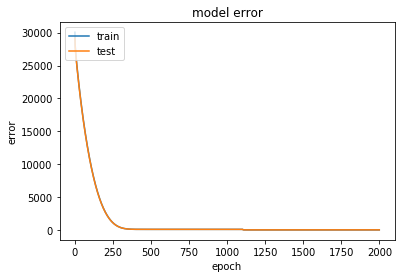

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model error')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
#print(error_prediction)

/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


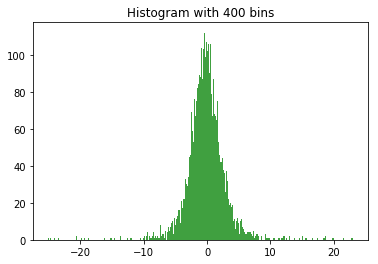

(400,)
(401,)
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 400
    # variables        = 3
    chi-square         = 4655.09024
    reduced chi-square = 11.7256681
    Akaike info crit   = 987.700812
    Bayesian info crit = 999.675205
[[Variables]]
    amp:  99.3568037 +/- 0.75854847 (0.76%) (init = 1000)
    cen: -0.27392505 +/- 0.01823456 (6.66%) (init = 0)
    wid:  2.92513794 +/- 0.02578757 (0.88%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, wid) = -0.577



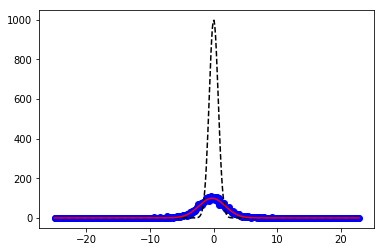

In [16]:

n, bins, patches = plt.hist(error_prediction, 400, normed=0, facecolor='green', alpha=0.75)
plt.title("Histogram with 400 bins")
plt.show()
x=bins[:400]
y=n
print(n.shape)
print(bins.shape)
from numpy import exp, loadtxt, pi, sqrt, log

from lmfit import Model
def gaussian(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return amp * exp(-((x-cen)/wid)**2 )


gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)

print(result.fit_report())

plt.plot(x, y, 'bo')
plt.plot(x, result.init_fit, 'k--')
plt.plot(x, result.best_fit, 'r-')
plt.show()





In [17]:
FWHM=result.params['wid'].value*2*sqrt(log(2))

In [18]:
print(FWHM)

4.8706741566513925


[[168.3171 ]
 [170.14659]
 [171.0259 ]
 ...
 [165.538  ]
 [171.03104]
 [170.93594]]


/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


4.396273662024103


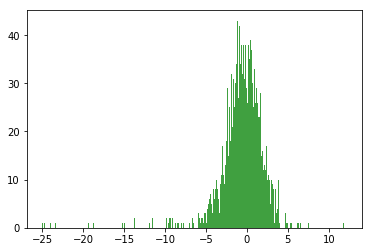

In [19]:
Y_test_bin0_predicted=model.predict(x_test_bin0)
print(Y_test_bin0_predicted)
error_prediction_bin0=Y_test_bin0-Y_test_bin0_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin0, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin0=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin0)

/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


4.54515513659975


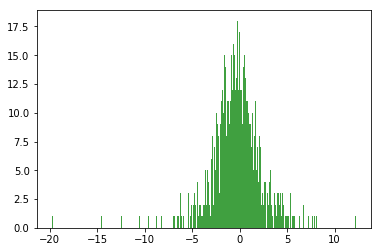

In [20]:
Y_test_bin1_predicted=model.predict(x_test_bin1)
#print(Y_test_bin1_predicted)
error_prediction_bin1=Y_test_bin1-Y_test_bin1_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin1, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin1=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin1)

/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


5.013891333679619


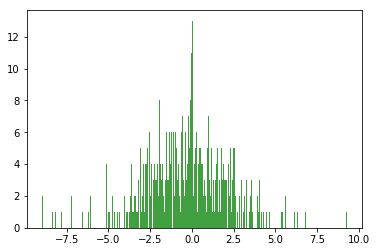

In [21]:
Y_test_bin2_predicted=model.predict(x_test_bin2)
#print(Y_test_bin2_predicted)
error_prediction_bin2=Y_test_bin2-Y_test_bin2_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin2, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin2=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin2)

/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


6.080539018702343


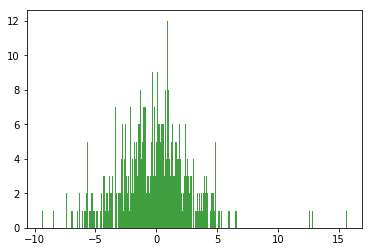

In [22]:
Y_test_bin3_predicted=model.predict(x_test_bin3)
#print(Y_test_bin3_predicted)
error_prediction_bin3=Y_test_bin3-Y_test_bin3_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin3, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin3=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin3)

/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


6.550721160335922
6.080539018702343
5.013891333679619
4.54515513659975
4.396273662024103


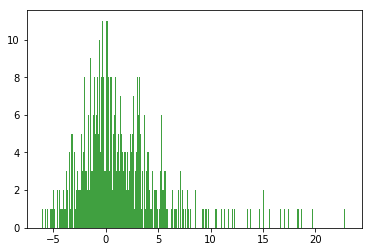

In [23]:
Y_test_bin4_predicted=model.predict(x_test_bin4)
#print(Y_test_bin4_predicted)
error_prediction_bin4=Y_test_bin4-Y_test_bin4_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin4, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin4=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin4)
print(FWHM_bin3)
print(FWHM_bin2)
print(FWHM_bin1)
print(FWHM_bin0)